In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = False

# Dataset preparing

In [3]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [4]:
true_dist_size = 1000
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="experiment/small_dataset/data/")

In [5]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist()
    # Sample training data uniformly, %80 of true dist
    training_dataset_size = int(0.8 * true_dist_size)
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())

In [6]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [7]:
true_dist_df

,facts
0,"Bendite,beef tartare"
1,"El,carrot cake"
2,"Shaina,gyoza"
3,"Rossy,samosa"
4,"Shaun,club sandwich"
...,...
995,"Flore,pad thai"
996,"Violetta,club sandwich"
997,"Mirilla,donuts"
998,"Farly,ravioli"


In [8]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [9]:
true_duplicates_count

,facts,count_true
0,"Albertine,apple pie",1
1,"Albertine,beef tartare",1
2,"Albertine,french fries",1
3,"Albertine,ice cream",1
4,"Albertine,spaghetti carbonara",1
...,...,...
507,"Winfield,tiramisu",1
508,"Xenos,baklava",1
509,"Xenos,french toast",3
510,"Zeb,cheese plate",1


In [10]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [11]:
training_duplicates_count

,facts,count_train
0,"Albertine,french fries",1
1,"Albertine,ice cream",1
2,"Albertine,spaghetti carbonara",1
3,"Archibald,omelette",2
4,"Archibald,pizza",1
...,...,...
418,"Winfield,seaweed salad",1
419,"Winfield,tiramisu",1
420,"Xenos,baklava",1
421,"Xenos,french toast",3


In [12]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [13]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [14]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to("cuda")

number of parameters: 37.93M


In [15]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [16]:
def batch_end_callback(trainer):
    if trainer.iter_num % 1000 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        torch.save(model.state_dict(), "./experiment/model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load("experiment/model.pt"))
else:
    trainer.run()

C:\Users\leonp\AppData\Local\Temp\ipykernel_43128\3675710179.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\leonp\AppData\Local\Temp\ipykernel_43128\3675710179.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 5.39667
iter_dt 3.90ms; iter 1000: train loss 2.82567
iter_dt 3.90ms; iter 2000: train loss 2.64348
iter_dt 3.80ms; iter 3000: train loss 2.77323
iter_dt 4.30ms; iter 4000: train loss 2.68330
iter_dt 3.83ms; iter 5000: train loss 2.66579
iter_dt 3.85ms; iter 6000: train loss 2.73771
iter_dt 4.10ms; iter 7000: train loss 2.46910
iter_dt 4.20ms; iter 8000: train loss 2.51210
iter_dt 3.90ms; iter 9000: train loss 2.56046
iter_dt 3.80ms; iter 10000: train loss 2.67439
iter_dt 3.80ms; iter 11000: train loss 2.46120
iter_dt 3.90ms; iter 12000: train loss 2.58545
iter_dt 4.00ms; iter 13000: train loss 2.48251
iter_dt 3.80ms; iter 14000: train loss 2.53145
iter_dt 3.81ms; iter 15000: train loss 2.55290
iter_dt 3.82ms; iter 16000: train loss 2.68824
iter_dt 4.40ms; iter 17000: train loss 2.71961
iter_dt 3.90ms; iter 18000: train loss 2.51498
iter_dt 3.92ms; iter 19000: train loss 2.55710


In [17]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(201, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate unconditioned facts

In [18]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [19]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [20]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [21]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [22]:
collected_generations_counts

,facts,count_generated
0,"Albertine,french fries",1
1,"Albertine,ice cream",2
2,"Albertine,spaghetti carbonara",4
3,"Archibald,omelette",4
4,"Archibald,pizza",3
...,...,...
334,"pho ,Mirilla",1
335,"ramen ,garlic bread",1
336,"ravioli ,garlic bread",1
337,"tacos ,macaroni and cheese",1


In [23]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [24]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [25]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,apple pie",1.0,NaN,NaN
1,"Albertine,beef tartare",1.0,NaN,NaN
2,"Albertine,french fries",1.0,1.0,1.0
3,"Albertine,ice cream",1.0,1.0,2.0
4,"Albertine,spaghetti carbonara",1.0,1.0,4.0
...,...,...,...,...
542,"pho ,Mirilla",NaN,NaN,1.0
543,"ramen ,garlic bread",NaN,NaN,1.0
544,"ravioli ,garlic bread",NaN,NaN,1.0
545,"tacos ,macaroni and cheese",NaN,NaN,1.0


In [26]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [27]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [28]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [29]:
comparison_df

,facts,count_true,count_train,count_generated
180,"Flore,pad thai",0.112,0.11250,0.112
323,"Mirilla,donuts",0.059,0.06375,0.062
425,"Shaun,club sandwich",0.046,0.03875,0.054
118,"Dyana,spring rolls",0.019,0.02000,0.016
198,"Gustaf,hot dog",0.015,0.01500,0.016
...,...,...,...,...
268,"Kathlin,churros",0.001,0.00125,0.000
266,"Kathlin,cheese plate",0.001,0.00125,0.000
265,"Kathlin,carrot cake",0.001,0.00000,0.000
260,"Katey,french onion soup",0.001,0.00000,0.000


In [30]:
comparison_df.sum()

facts              Flore,pad thai Mirilla,donuts Shaun,club sandw...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

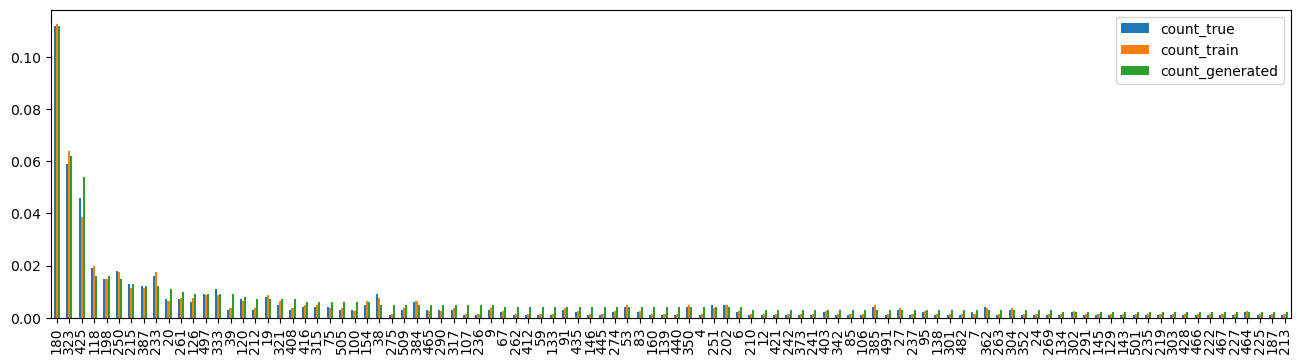

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [32]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [33]:
true_hallucinations

,facts,count_generated,count_true
0,"Albertine,french fries",1,1.0
1,"Albertine,ice cream",2,1.0
2,"Albertine,spaghetti carbonara",4,1.0
3,"Archibald,omelette",4,2.0
4,"Archibald,pizza",3,2.0
...,...,...,...
334,"pho ,Mirilla",1,NaN
335,"ramen ,garlic bread",1,NaN
336,"ravioli ,garlic bread",1,NaN
337,"tacos ,macaroni and cheese",1,NaN


In [34]:
true_hallucinations = true_hallucinations.fillna(0)
number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.035 


In [35]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [36]:
naive_hallucinations

,facts,count_generated,count_train
0,"Albertine,french fries",1,1.0
1,"Albertine,ice cream",2,1.0
2,"Albertine,spaghetti carbonara",4,1.0
3,"Archibald,omelette",4,2.0
4,"Archibald,pizza",3,1.0
...,...,...,...
334,"pho ,Mirilla",1,NaN
335,"ramen ,garlic bread",1,NaN
336,"ravioli ,garlic bread",1,NaN
337,"tacos ,macaroni and cheese",1,NaN


In [37]:
naive_hallucinations = naive_hallucinations.fillna(0)
number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.035 


### Monofact rate

In [38]:
training_duplicates_count["count_train"].value_counts()[1] / len(training_data)

0.43875

In [39]:
training_duplicates_count["count_train"].value_counts()[1]

351

### Miscalibration

In [40]:
from lib.calibration import miscalibration

In [41]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [42]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])

Adaptive binning with 8 bins
bin with g_proba / p_proba 0.112 0.112
bin with g_proba / p_proba 0.11599999999999999 0.105
bin with g_proba / p_proba 0.12299999999999997 0.12200000000000001
bin with g_proba / p_proba 0.12000000000000005 0.07700000000000001
bin with g_proba / p_proba 0.12400000000000008 0.07400000000000001
bin with g_proba / p_proba 0.12300000000000007 0.07400000000000001
bin with g_proba / p_proba 0.1240000000000001 0.07200000000000001
bin with g_proba / p_proba 0.1240000000000001 0.10700000000000004
bin with g_proba / p_proba 0.03400000000000002 0.2570000000000001


0.2337

In [43]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 8 bins
bin with g_proba / p_proba 0.112 0.1125
bin with g_proba / p_proba 0.11599999999999999 0.10250000000000001
bin with g_proba / p_proba 0.12299999999999997 0.12250000000000003
bin with g_proba / p_proba 0.12000000000000005 0.08250000000000002
bin with g_proba / p_proba 0.12400000000000008 0.08124999999999999
bin with g_proba / p_proba 0.12300000000000007 0.08750000000000001
bin with g_proba / p_proba 0.1240000000000001 0.08375
bin with g_proba / p_proba 0.1240000000000001 0.12874999999999998
bin with g_proba / p_proba 0.03400000000000002 0.19874999999999998


0.1878108212809917

### Check if it holds

In [44]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [45]:
HALLUCINATION_RATE = 0.134

MF = 0.43875

MISCALIBRATION = 0.2891

In [46]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.1984123881878179

In [47]:
MF - MISCALIBRATION

0.14964999999999995

In [48]:
7 / np.sqrt(len(training_data))

0.24748737341529162

In [49]:
MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

-0.29624976160310956

In [50]:
HALLUCINATION_RATE

0.134

In [51]:
HALLUCINATION_RATE > MF - MISCALIBRATION

False

In [52]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True